In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import timeit

In [2]:
df = pd.read_csv('train.csv',nrows=10000)

In [3]:
df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [4]:
df.shape

(10000, 8)

In [5]:
df.describe()

,toxic,severe_toxic,obscene,threat,insult,identity_hate
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000
mean,0.097100,0.010100,0.052700,0.003300,0.049400,0.00840
std,0.296109,0.099995,0.223445,0.057354,0.216713,0.09127
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000


In [6]:
%timeit True if 1 in df.loc[0][['toxic','severe_toxic','obscene','threat','insult','identity_hate']] else False

589 µs ± 30.1 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [7]:
%timeit any(i == 1 for i in df.loc[0][['toxic','severe_toxic','obscene','threat','insult','identity_hate']])

587 µs ± 22.1 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [6]:
df['target'] = df.apply(lambda x: any(i == 1 for i in x[['toxic','severe_toxic','obscene','threat','insult','identity_hate']]), axis=1)

In [7]:
df = df.drop(['id','toxic','severe_toxic','obscene','threat','insult','identity_hate'],axis=1)

In [10]:
df.head(10)

,comment_text,target
0,Explanation\nWhy the edits made under my usern...,False
1,D'aww! He matches this background colour I'm s...,False
2,"Hey man, I'm really not trying to edit war. It...",False
3,"""\nMore\nI can't make any real suggestions on ...",False
4,"You, sir, are my hero. Any chance you remember...",False
5,"""\n\nCongratulations from me as well, use the ...",False
6,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,True
7,Your vandalism to the Matt Shirvington article...,False
8,Sorry if the word 'nonsense' was offensive to ...,False
9,alignment on this subject and which are contra...,False


In [42]:
test = pd.read_csv('test.csv')

In [43]:
test.head()

,id,comment_text
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap..."
3,00017563c3f7919a,":If you have a look back at the source, the in..."
4,00017695ad8997eb,I don't anonymously edit articles at all.


In [9]:
import re, string
re_tok = re.compile(f'([{string.punctuation}“”¨«»®´·º½¾¿¡§£₤‘’])')
def tokenize(s): return re_tok.sub(r' \1 ', s).split()

In [10]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

In [44]:
vec = TfidfVectorizer(max_features=2000,ngram_range=(1,3), tokenizer=tokenize,
               min_df=3, max_df=0.9, strip_accents='unicode', use_idf=1,
               smooth_idf=1, sublinear_tf=1,stop_words='english')
trn_term_doc = vec.fit_transform(df['comment_text'])
test_term_doc = vec.transform(test['comment_text'])

In [60]:
import pickle

with open('vectorizer.pk', 'wb') as fin:
    pickle.dump(vec, fin)

In [61]:
with open('NaiveBayes_model.pk', 'wb') as fin:
    pickle.dump(gnb, fin)

In [34]:
from sklearn.model_selection import train_test_split
from sklearn import metrics

from sklearn.naive_bayes import GaussianNB,MultinomialNB
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier

In [45]:
train = pd.DataFrame(trn_term_doc.toarray(), 
                    columns=vec.get_feature_names())

In [46]:
test = pd.DataFrame(test_term_doc.toarray(), 
                    columns=vec.get_feature_names())

In [47]:
X_train, X_test, y_train, y_test = train_test_split(train, df['target'], test_size=0.2, random_state=0)

In [37]:
gnb = GaussianNB()
y_pred = gnb.fit(X_train, y_train).predict(X_test)

# Calculate the accuracy score: score
score = metrics.accuracy_score(y_test, y_pred)
print('Accuracy is:',score)
f1 = metrics.f1_score(y_test, y_pred)
print('F score is:',f1)

Accuracy is: 0.7085
F score is: 0.3710895361380798


In [38]:
recall = metrics.recall_score(y_test, y_pred)
print('Recall score is:',recall)

Recall score is: 0.7962962962962963


In [51]:
alpha = [0.1,0.5,0.75,0.8,0.9,1]

for i in alpha:
    gnb = GaussianNB(var_smoothing=i)
    y_pred = gnb.fit(X_train, y_train).predict(X_test)

    # Calculate the accuracy score: score
    print('Alpha is: ',i)
    score = metrics.accuracy_score(y_test, y_pred)
    print('Accuracy is:',score)
    f1 = metrics.f1_score(y_test, y_pred)
    print('F score is:',f1)
    recall = metrics.recall_score(y_test, y_pred)
    print('Recall score is:',recall)

Alpha is:  0.1
Accuracy is: 0.377
F score is: 0.2529976019184652
Recall score is: 0.9768518518518519
Alpha is:  0.5
Accuracy is: 0.2795
F score is: 0.22817354043920732
Recall score is: 0.9861111111111112
Alpha is:  0.75
Accuracy is: 0.4485
F score is: 0.2776686313032089
Recall score is: 0.9814814814814815
Alpha is:  0.8
Accuracy is: 0.4955
F score is: 0.29588276343335657
Recall score is: 0.9814814814814815
Alpha is:  0.9
Accuracy is: 0.5945
F score is: 0.33795918367346933
Recall score is: 0.9583333333333334
Alpha is:  1
Accuracy is: 0.6735
F score is: 0.37868696479543285
Recall score is: 0.9212962962962963


In [52]:
gnb = GaussianNB(var_smoothing=0.9)
y_pred = gnb.fit(X_train, y_train).predict(X_test)

# Calculate the accuracy score: score
print('Alpha is: 0.1')
score = metrics.accuracy_score(y_test, y_pred)
print('Accuracy is:',score)
f1 = metrics.f1_score(y_test, y_pred)
print('F score is:',f1)
recall = metrics.recall_score(y_test, y_pred)
print('Recall score is:',recall)

Alpha is: 0.1
Accuracy is: 0.5945
F score is: 0.33795918367346933
Recall score is: 0.9583333333333334


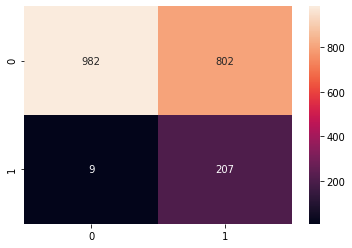

In [53]:
sns.heatmap(metrics.confusion_matrix(y_test,y_pred),annot=True,fmt='2.0f')

In [55]:
from sklearn.pipeline import make_pipeline

In [56]:
model = make_pipeline(TfidfVectorizer(max_features=2000,ngram_range=(1,3), tokenizer=tokenize,
                       min_df=3, max_df=0.9, strip_accents='unicode', use_idf=1,
                       smooth_idf=1, sublinear_tf=1,stop_words='english'),
                     GaussianNB(var_smoothing=0.9))

In [ ]:
def vec(X,y):
    text_vec = TfidfVectorizer(max_features=2000,ngram_range=(1,3), tokenizer=tokenize,
                       min_df=3, max_df=0.9, strip_accents='unicode', use_idf=1,
                       smooth_idf=1, sublinear_tf=1,stop_words='english')
    

In [57]:
model.fit(X_train, y_train)

TypeError: A sparse matrix was passed, but dense data is required. Use X.toarray() to convert to a dense numpy array.

In [23]:
svm = svm.SVC()
y_pred2 = svm.fit(X_train, y_train).predict(X_test)

# Calculate the accuracy score: score
score = metrics.accuracy_score(y_test, y_pred2)
print('Accuracy for SVC is:',score)
f1 = metrics.f1_score(y_test, y_pred2)
print('F score for SVC is:',f1)
recall = metrics.recall_score(y_test, y_pred2)
print('Recall score for SVC is:',recall)


Accuracy for SVC is: 0.93525
F score for SVC is: 0.5632377740303541
Recall score for SVC is: 0.40047961630695444


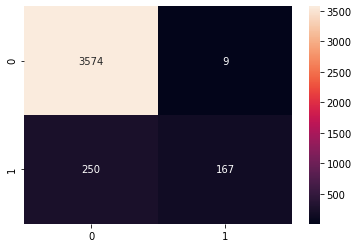

In [27]:
sns.heatmap(metrics.confusion_matrix(y_test,y_pred2),annot=True,fmt='2.0f')

In [25]:
rf = RandomForestClassifier()
y_pred3 = rf.fit(X_train, y_train).predict(X_test)

# Calculate the accuracy score: score
score = metrics.accuracy_score(y_test, y_pred3)
print('Accuracy for RandomForestClassifier is:',score)
f1 = metrics.f1_score(y_test, y_pred3)
print('F score for RandomForestClassifier is:',f1)
recall = metrics.recall_score(y_test, y_pred3)
print('Recall score for RandomForestClassifier is:',recall)

Accuracy for RandomForestClassifier is: 0.93525
F score for RandomForestClassifier is: 0.5788617886178862
Recall score for RandomForestClassifier is: 0.42685851318944845


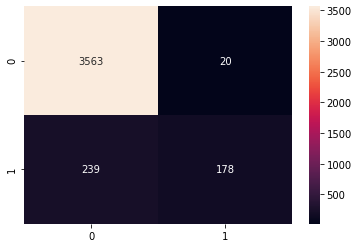

In [26]:
sns.heatmap(metrics.confusion_matrix(y_test,y_pred3),annot=True,fmt='2.0f')